# Развёртывание датасета

Импортируем необходимые библиотеки

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

Загружаем данные, после чего удаляем пустые колонки

In [3]:
dataset = pd.read_csv('Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv', 
                   dtype={'Violation Location' : object})

#Drop null columns
dataset.drop(dataset.columns[range(40, 51)], axis=1, inplace=True)

C:\Users\Sandor\AppData\Local\Temp\ipykernel_2228\3378627436.py:1: DtypeWarning: Columns (17,18,20,21,22,23,29,30,31,32,36,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv',


Конвертируем поле 'Issue Date' в дату, затем оставляем в датасете только те строки, в которых автомобиль одна из трёх следующих марок: 'DODGE', 'TOYOT', 'HYUND', а дата "происшествия" находится в периоде между 2013-01-01 и 2015-01-01.

In [4]:
dataset['Issue Date'] = dataset['Issue Date'].apply(pd.to_datetime)

In [5]:
dataset = dataset.loc[(dataset['Vehicle Make'].isin(['DODGE', 'TOYOT', 'HYUND'])) & 
                      ((dataset['Issue Date'] >= pd.Timestamp('2013-01-01')) & (dataset['Issue Date'] <= pd.Timestamp('2015-01-01'))) & 
                      ((dataset['Vehicle Year'] >= 1900.0) & (dataset['Vehicle Year'] <= 2015.0))]

In [6]:
dataset.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description
8,1283983631,GBH9379,NY,PAS,2013-08-07,24,SDN,TOYOT,X,63430,...,BBBBBBB,ALL,ALL,WHITE,0.0,2001.0,-,0.0,NaN,NaN
10,1283983679,M367CN,NY,PAS,2013-07-18,24,SDN,HYUND,H,0,...,BBBBBBB,ALL,ALL,BLUE,0.0,2010.0,-,0.0,NaN,NaN
11,1283983734,GAR6813,NY,PAS,2013-07-18,24,SDN,TOYOT,H,0,...,BBBBBBB,ALL,ALL,TAN,0.0,1998.0,-,0.0,NaN,NaN
16,1286246398,GFC5338,NY,PAS,2013-07-26,14,SDN,TOYOT,T,0,...,YYYYYYY,0800A,1000P,GRAY,0.0,2010.0,-,0.0,NaN,NaN
23,1286799648,GDE3973,NY,PAS,2013-07-20,40,SDN,TOYOT,T,0,...,BBBBBBB,ALL,ALL,TN,0.0,2003.0,-,9.0,NaN,NaN


In [7]:
dataset.tail()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description
9100243,8006050405,APZ5782,NY,PAS,2014-06-25,20,SUBN,TOYOT,T,9140,...,YYYYY,0800A,0600P,SILVE,NaN,2007.0,NaN,0.0,06 4,20A-No Parking (Non-COM)
9100248,8006050491,EGX5038,NY,PAS,2014-06-25,37,SUBN,TOYOT,T,9540,...,Y,0800A,1000P,GY,NaN,2008.0,406-9426,0.0,06 4,37-Expired Muni Meter
9100249,8006050508,DHE4798,NY,PAS,2014-06-25,37,SUBN,TOYOT,T,9540,...,Y,0800A,1000P,GY,NaN,2005.0,406-9424,0.0,06 4,37-Expired Muni Meter
9100261,8006100214,FYD4422,NY,PAS,2014-06-24,21,4DSD,TOYOT,T,67530,...,Y Y,1130A,0100P,WH,NaN,2012.0,NaN,0.0,08 3,21-No Parking (street clean)
9100271,8006150151,CWN4247,NY,PAS,2014-06-25,37,SUBN,TOYOT,T,0,...,YYYYYYY,NaN,NaN,GY,NaN,2004.0,373-0123,0.0,10 3,37-Expired Muni Meter


In [8]:
dataset.drop(columns=dataset.columns.difference(['Issue Date', 'Vehicle Make', 'Violation Time', 'House Number', 'Street Name', 'Vehicle Year']), axis=1, inplace=True)
dataset.head()

,Issue Date,Vehicle Make,Violation Time,House Number,Street Name,Vehicle Year
8,2013-08-07,TOYOT,0437A,100,N.PORTLAND AVE,2001.0
10,2013-07-18,HYUND,0845A,NaN,760 BROADWAY BROOKLY,2010.0
11,2013-07-18,TOYOT,0907A,NaN,760 BROADWAY BROOKLY,1998.0
16,2013-07-26,TOYOT,1142A,145,PROSPECT PKWAY,2010.0
23,2013-07-20,TOYOT,0324P,NaN,E/S RIVER TER.,2003.0


In [9]:
dataset.tail()

,Issue Date,Vehicle Make,Violation Time,House Number,Street Name,Vehicle Year
9100243,2014-06-25,TOYOT,1104A,W,39th Ave,2007.0
9100248,2014-06-25,TOYOT,0103P,133-32,41st Ave,2008.0
9100249,2014-06-25,TOYOT,0105P,133-24,41st Ave,2005.0
9100261,2014-06-24,TOYOT,1140A,560,Ocean Ave,2012.0
9100271,2014-06-25,TOYOT,0115P,NaN,Other-See Comments,2004.0


In [53]:
dataset.set_index('Issue Date',inplace=True)

In [11]:
dataset.head()

,Vehicle Make,Violation Time,House Number,Street Name,Vehicle Year
Issue Date,,,,,
2013-08-07,TOYOT,0437A,100,N.PORTLAND AVE,2001.0
2013-07-18,HYUND,0845A,NaN,760 BROADWAY BROOKLY,2010.0
2013-07-18,TOYOT,0907A,NaN,760 BROADWAY BROOKLY,1998.0
2013-07-26,TOYOT,1142A,145,PROSPECT PKWAY,2010.0
2013-07-20,TOYOT,0324P,NaN,E/S RIVER TER.,2003.0


In [12]:
dataset.tail()

,Vehicle Make,Violation Time,House Number,Street Name,Vehicle Year
Issue Date,,,,,
2014-06-25,TOYOT,1104A,W,39th Ave,2007.0
2014-06-25,TOYOT,0103P,133-32,41st Ave,2008.0
2014-06-25,TOYOT,0105P,133-24,41st Ave,2005.0
2014-06-24,TOYOT,1140A,560,Ocean Ave,2012.0
2014-06-25,TOYOT,0115P,NaN,Other-See Comments,2004.0


In [13]:
dataset.describe()

,Vehicle Year
count,1.066655e+06
mean,2.007093e+03
std,5.155833e+00
min,1.970000e+03
25%,2.004000e+03
50%,2.008000e+03
75%,2.012000e+03
max,2.015000e+03


# Визуализируем датасет

### Проанализируем данные о всех штрафах

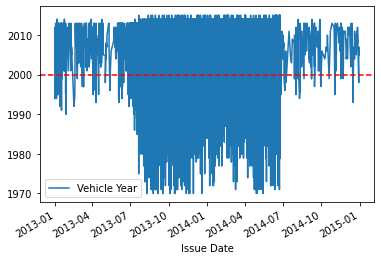

In [14]:
ax = dataset.plot()
ax.axhline(2000, color="red", linestyle="--")

Красная вертикальная линия отделяет штрафы, полученные машинами выпущенные до 2000 года и после.
Как видно, больше всего штрафов приходится на период от 2013-07 до 2014-07, но машины выпущенные до 2000 года получили гораздо меньше штрафов в остальной период времени, нежели машины выпущенные после 2000 года.

### Рассмотрим отдельно графики для машин разных марок.

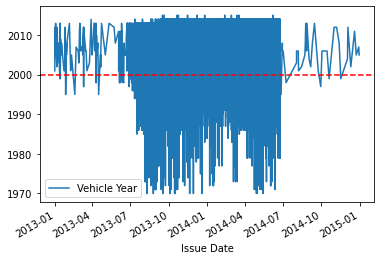

In [15]:
ax = dataset.loc[dataset['Vehicle Make']=='DODGE'].plot()
ax.axhline(2000, color="red", linestyle="--")

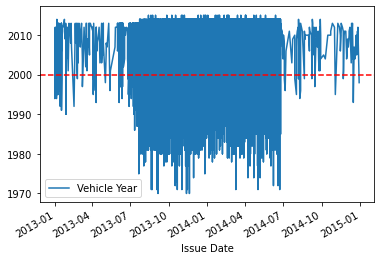

In [16]:
ax = dataset.loc[dataset['Vehicle Make']=='TOYOT'].plot()
ax.axhline(2000, color="red", linestyle="--")

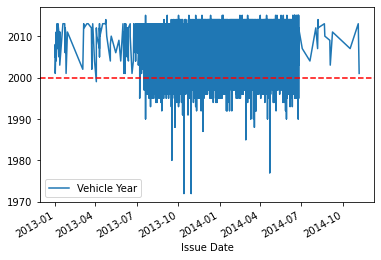

In [17]:
ax = dataset.loc[dataset['Vehicle Make']=='HYUND'].plot()
ax.axhline(2000, color="red", linestyle="--")

Первые два графика не сильно отличаются, но третий выделяется сильнее. Как видно машины марки "Hyundai" намного реже получали штрафы в период с 2013-01 до 2013-07 и с 2014-07 до 2015-01.
При этом машины, выпущенные до 2000 года, практически не попадали в "неприятности", особенно это прослеживается на вышесказанном периоде времени.

### Рассмотрим где чаще всего происходили нарушения

Выведем список улиц, которые находятся в топе по количеству нарушений

In [18]:
dataset['Street Name'].value_counts().head(5)

Broadway                19464
3rd Ave                 11780
5th Ave                 10132
Queens Blvd              7953
WB FORDHAM RD @ MARI     7239
Name: Street Name, dtype: int64

Выведем для вышеперечисленных улиц номера домов, где чаще всего происходят нарушения

In [19]:
dataset.loc[dataset['Street Name'].isin(dataset['Street Name'].value_counts().head(5).index)].groupby('Street Name')['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,3rd Ave,W,578
1687,5th Ave,E,319
3185,Broadway,W,716
5573,Queens Blvd,N,395


### Рассмотрим результаты отдельно для машин разных марок

#### Dodge

##### До 2000 года

In [20]:
dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5)

Broadway       358
3rd Ave        241
Jamaica Ave    171
5th Ave        160
2nd Ave        152
Name: Street Name, dtype: int64

<AxesSubplot:>

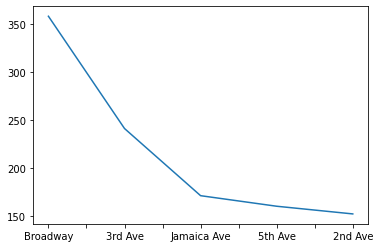

In [21]:
dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5).plot()

In [22]:
dataset.loc[dataset['Street Name'].isin(dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5).index) & (dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] < 2000.0)].groupby('Street Name')['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,2nd Ave,1546,17
80,3rd Ave,W,13
262,5th Ave,E,9
387,Broadway,W,17
634,Jamaica Ave,S,6


##### После 2000 года

In [23]:
dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5)

Broadway         4509
3rd Ave          3115
Madison Ave      2175
5th Ave          2063
Lexington Ave    1622
Name: Street Name, dtype: int64

<AxesSubplot:>

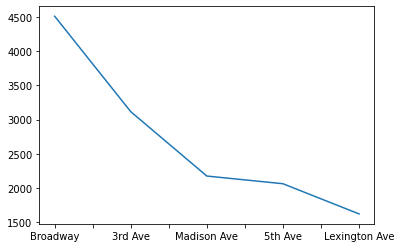

In [24]:
dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5).plot()

In [25]:
dataset.loc[dataset['Street Name'].isin(dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5).index) & (dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] >= 2000.0)].groupby('Street Name')['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,3rd Ave,W,161
970,5th Ave,E,118
1776,Broadway,W,169
3100,Lexington Ave,E,62
3538,Madison Ave,W,142


#### Toyota

##### До 2000 года

In [26]:
dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5)

Broadway       989
Jamaica Ave    737
3rd Ave        627
Queens Blvd    564
5th Ave        558
Name: Street Name, dtype: int64

<AxesSubplot:>

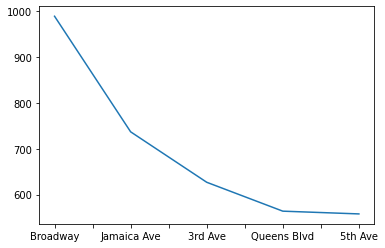

In [27]:
dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5).plot()

In [28]:
dataset.loc[dataset['Street Name'].isin(dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5).index) & (dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] < 2000.0)].groupby('Street Name')['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,3rd Ave,W,31
397,5th Ave,E,13
781,Broadway,W,36
1369,Jamaica Ave,S,18
1859,Queens Blvd,N,29


##### После 2000 года

In [29]:
dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5)

Broadway                11602
3rd Ave                  6399
5th Ave                  5907
WB FORDHAM RD @ MARI     5490
Queens Blvd              4728
Name: Street Name, dtype: int64

<AxesSubplot:>

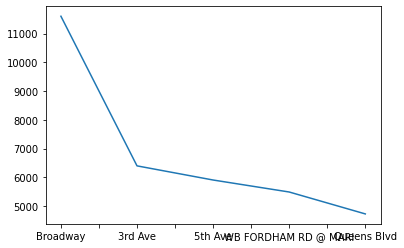

In [30]:
dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5).plot()

In [31]:
dataset.loc[dataset['Street Name'].isin(dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5).index) & (dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] >= 2000.0)].groupby('Street Name')['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,3rd Ave,W,323
1351,5th Ave,E,143
2645,Broadway,W,425
4627,Queens Blvd,N,248


#### Hyundai

##### До 2000 года

In [32]:
dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5)

Broadway                16
5th Ave                 14
E 3rd St                12
HORACE HARDING EXPWY    12
3rd Ave                 11
Name: Street Name, dtype: int64

<AxesSubplot:>

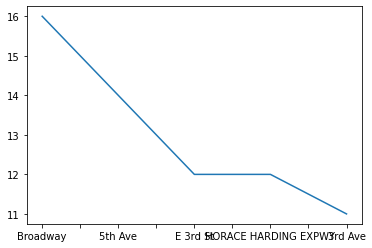

In [33]:
dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5).plot()

In [34]:
dataset.loc[dataset['Street Name'].isin(dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5).index) & (dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] < 2000.0)].groupby('Street Name')['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,3rd Ave,1317,1
11,5th Ave,E,5
19,Broadway,E,2
34,E 3rd St,150,3


##### После 2000 года

In [35]:
dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5)

Broadway                1990
5th Ave                 1430
3rd Ave                 1387
Queens Blvd             1282
HORACE HARDING EXPWY    1173
Name: Street Name, dtype: int64

<AxesSubplot:>

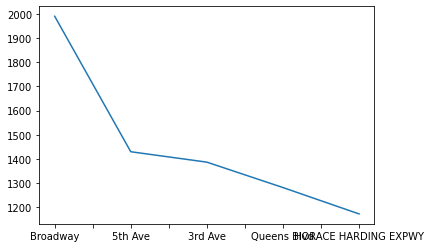

In [36]:
dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5).plot()

In [37]:
dataset.loc[dataset['Street Name'].isin(dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5).index) & (dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] >= 2000.0)].groupby('Street Name')['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,3rd Ave,W,50
732,5th Ave,E,31
1384,Broadway,E,94
2276,HORACE HARDING EXPWY,183-20,1
2278,Queens Blvd,N,51


### Сгруппируем данные по дням и количеству штрафов в этот день

<AxesSubplot:xlabel='Issue Date'>

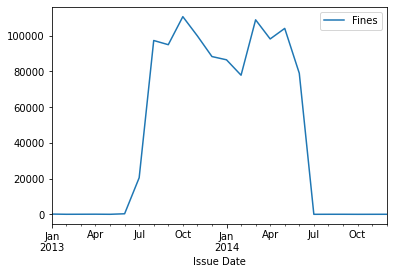

In [325]:
finecount_bydate = pd.DataFrame(dataset.reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'})
finecount_bydate.plot()

In [326]:
finecount_bydate_before2000 = { 'ALL' : pd.DataFrame(dataset.loc[dataset['Vehicle Year'] < 2000.0].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}), 
                                'DODGE' : pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] < 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}), 
                                'TOYOT' : pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] < 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}), 
                                'HYUND' : pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] < 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'})} 
                    
finecount_bydate_after2000 = { 'ALL' : pd.DataFrame(dataset.loc[dataset['Vehicle Year'] >= 2000.0].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}), 
                                'DODGE' : pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] >= 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}), 
                                'TOYOT' : pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] >= 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}), 
                                'HYUND' : pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] >= 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'})} 

Рассмотрим штрафы машин выпещенных до 2000 года.

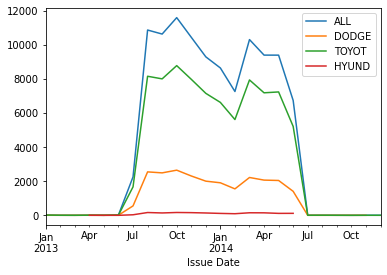

In [327]:
fig, ax = plt.subplots()
finecount_bydate_before2000['ALL'].plot(legend=True, ax=ax)
finecount_bydate_before2000['DODGE'].plot(legend=True, ax=ax)
finecount_bydate_before2000['TOYOT'].plot(legend=True, ax=ax)
finecount_bydate_before2000['HYUND'].plot(legend=True, ax=ax)
plt.legend(['ALL', 'DODGE', 'TOYOT', 'HYUND']);

Как видно на графике, больше всего штрафов получают машины марки "Toyota", затем идут "Dodge, ну и последними, практически с нулем штрафов идут машины марки "Hyundai".

Рассмотрим штрафы машин выпещенных после 2000 года.

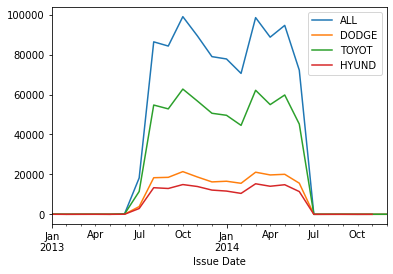

In [328]:
fig, ax = plt.subplots()
finecount_bydate_after2000['ALL'].plot(legend=True, ax=ax)
finecount_bydate_after2000['DODGE'].plot(legend=True, ax=ax)
finecount_bydate_after2000['TOYOT'].plot(legend=True, ax=ax)
finecount_bydate_after2000['HYUND'].plot(legend=True, ax=ax)
plt.legend(['ALL', 'DODGE', 'TOYOT', 'HYUND']);

Здесь ситуация не сильно изменилась, единственное: машины марки "Hyundai" получили гораздно больше штрафов, практически столько же, сколько и машины марки "Dodge".

In [329]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

### Дифференциация

In [330]:
adfuller_test(finecount_bydate['Fines'])

ADF Test Statistic : -1.8661294870672636
p-value : 0.34815871150642486
#Lags Used : 9
Number of Observations Used : 14
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Посмотрим как меняется количество штрафов каждый месяц

In [332]:
finecount_bydate['Fines First Difference'] = finecount_bydate['Fines'] - finecount_bydate['Fines'].shift(1)
finecount_bydate.head()

,Fines,Fines First Difference
Issue Date,,
2013-01-31,146,NaN
2013-02-28,30,-116.0
2013-03-31,52,22.0
2013-04-30,79,27.0
2013-05-31,23,-56.0


Посмотрим как меняется количество штрафов каждый год

In [335]:
finecount_bydate['Seasonal First Difference']=finecount_bydate['Fines']-finecount_bydate['Fines'].shift(12)
finecount_bydate.head(20)

,Fines,Fines First Difference,Seasonal First Difference
Issue Date,,,
2013-01-31,146,NaN,NaN
2013-02-28,30,-116.0,NaN
2013-03-31,52,22.0,NaN
2013-04-30,79,27.0,NaN
2013-05-31,23,-56.0,NaN
2013-06-30,315,292.0,NaN
2013-07-31,20471,20156.0,NaN
2013-08-31,97285,76814.0,NaN
2013-09-30,94944,-2341.0,NaN


In [336]:
adfuller_test(finecount_bydate['Seasonal First Difference'].dropna())

ADF Test Statistic : 0.2327911176361024
p-value : 0.9740419290505016
#Lags Used : 4
Number of Observations Used : 7
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<AxesSubplot:xlabel='Issue Date'>

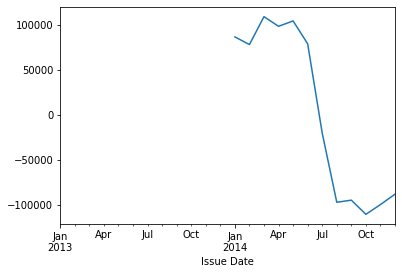

In [337]:
finecount_bydate['Seasonal First Difference'].plot()

#### Посмотрим как меняется количество штрафов каждый год для разных марок машин

##### До 2000 года

###### Dodge

In [338]:
adfuller_test(finecount_bydate_before2000['DODGE']['Fines'])

ADF Test Statistic : -1.6260738138629365
p-value : 0.46954649539680676
#Lags Used : 9
Number of Observations Used : 13
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [341]:
finecount_bydate_before2000['DODGE']['Fines First Difference'] = finecount_bydate_before2000['DODGE']['Fines'] - finecount_bydate_before2000['DODGE']['Fines'].shift(1)
finecount_bydate_before2000['DODGE'].head()

,Fines,Fines First Difference
Issue Date,,
2013-01-31,4,NaN
2013-02-28,1,-3.0
2013-03-31,1,0.0
2013-04-30,3,2.0
2013-05-31,0,-3.0


In [343]:
finecount_bydate_before2000['DODGE']['Seasonal First Difference']=finecount_bydate_before2000['DODGE']['Fines']-finecount_bydate_before2000['DODGE']['Fines'].shift(12)
finecount_bydate_before2000['DODGE'].head(20)

,Fines,Fines First Difference,Seasonal First Difference
Issue Date,,,
2013-01-31,4,NaN,NaN
2013-02-28,1,-3.0,NaN
2013-03-31,1,0.0,NaN
2013-04-30,3,2.0,NaN
2013-05-31,0,-3.0,NaN
2013-06-30,9,9.0,NaN
2013-07-31,553,544.0,NaN
2013-08-31,2549,1996.0,NaN
2013-09-30,2491,-58.0,NaN


In [344]:
adfuller_test(finecount_bydate_before2000['DODGE']['Seasonal First Difference'].dropna())

ADF Test Statistic : -1.0175277030046914
p-value : 0.7468179148196714
#Lags Used : 1
Number of Observations Used : 9
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<AxesSubplot:xlabel='Issue Date'>

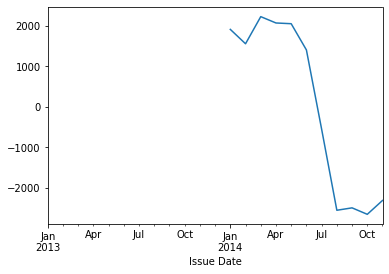

In [345]:
finecount_bydate_before2000['DODGE']['Seasonal First Difference'].plot()

###### Toyota

In [346]:
adfuller_test(finecount_bydate_before2000['TOYOT']['Fines'])

ADF Test Statistic : -2.022623252878811
p-value : 0.2767425241024694
#Lags Used : 9
Number of Observations Used : 14
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [348]:
finecount_bydate_before2000['TOYOT']['Fines First Difference'] = finecount_bydate_before2000['TOYOT']['Fines'] - finecount_bydate_before2000['TOYOT']['Fines'].shift(1)
finecount_bydate_before2000['TOYOT'].head()

,Fines,Fines First Difference
Issue Date,,
2013-01-31,14,NaN
2013-02-28,3,-11.0
2013-03-31,1,-2.0
2013-04-30,6,5.0
2013-05-31,2,-4.0


In [349]:
finecount_bydate_before2000['TOYOT']['Seasonal First Difference']=finecount_bydate_before2000['TOYOT']['Fines']-finecount_bydate_before2000['TOYOT']['Fines'].shift(12)
finecount_bydate_before2000['TOYOT'].head(20)

,Fines,Fines First Difference,Seasonal First Difference
Issue Date,,,
2013-01-31,14,NaN,NaN
2013-02-28,3,-11.0,NaN
2013-03-31,1,-2.0,NaN
2013-04-30,6,5.0,NaN
2013-05-31,2,-4.0,NaN
2013-06-30,15,13.0,NaN
2013-07-31,1671,1656.0,NaN
2013-08-31,8161,6490.0,NaN
2013-09-30,8008,-153.0,NaN


In [350]:
adfuller_test(finecount_bydate_before2000['TOYOT']['Seasonal First Difference'].dropna())

ADF Test Statistic : -1.0861611085989757
p-value : 0.7205590250965523
#Lags Used : 1
Number of Observations Used : 10
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<AxesSubplot:xlabel='Issue Date'>

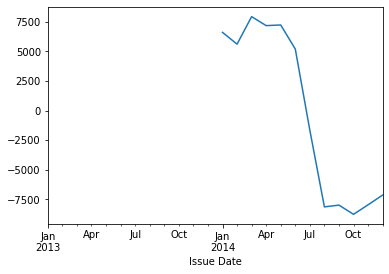

In [351]:
finecount_bydate_before2000['TOYOT']['Seasonal First Difference'].plot()

###### Hyundai

In [352]:
adfuller_test(finecount_bydate_before2000['HYUND']['Fines'])

ADF Test Statistic : -5.753771985945948
p-value : 5.883926947423704e-07
#Lags Used : 5
Number of Observations Used : 9
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [353]:
finecount_bydate_before2000['HYUND']['Fines First Difference'] = finecount_bydate_before2000['HYUND']['Fines'] - finecount_bydate_before2000['HYUND']['Fines'].shift(1)
finecount_bydate_before2000['HYUND'].head()

,Fines,Fines First Difference
Issue Date,,
2013-04-30,1,NaN
2013-05-31,0,-1.0
2013-06-30,0,0.0
2013-07-31,32,32.0
2013-08-31,164,132.0


In [354]:
finecount_bydate_before2000['HYUND']['Seasonal First Difference']=finecount_bydate_before2000['HYUND']['Fines']-finecount_bydate_before2000['HYUND']['Fines'].shift(12)
finecount_bydate_before2000['HYUND'].head(20)

,Fines,Fines First Difference,Seasonal First Difference
Issue Date,,,
2013-04-30,1,NaN,NaN
2013-05-31,0,-1.0,NaN
2013-06-30,0,0.0,NaN
2013-07-31,32,32.0,NaN
2013-08-31,164,132.0,NaN
2013-09-30,139,-25.0,NaN
2013-10-31,166,27.0,NaN
2013-11-30,157,-9.0,NaN
2013-12-31,137,-20.0,NaN


In [372]:
adfuller_test(finecount_bydate_before2000['HYUND']['Seasonal First Difference'].dropna())

ADF Test Statistic : -0.27034286953423037
p-value : 0.9296009086542498
#Lags Used : 0
Number of Observations Used : 10
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<AxesSubplot:xlabel='Issue Date'>

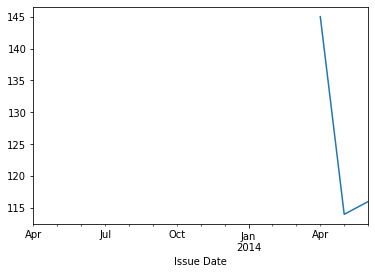

In [374]:
finecount_bydate_before2000['HYUND']['Seasonal First Difference'].plot()

##### После 2000 года

###### Dodge

In [355]:
adfuller_test(finecount_bydate_after2000['DODGE']['Fines'])

ADF Test Statistic : -1.8641445916684725
p-value : 0.3491119713287373
#Lags Used : 9
Number of Observations Used : 14
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [356]:
finecount_bydate_after2000['DODGE']['Fines First Difference'] = finecount_bydate_after2000['DODGE']['Fines'] - finecount_bydate_after2000['DODGE']['Fines'].shift(1)
finecount_bydate_after2000['DODGE'].head()

,Fines,Fines First Difference
Issue Date,,
2013-01-31,35,NaN
2013-02-28,7,-28.0
2013-03-31,17,10.0
2013-04-30,20,3.0
2013-05-31,4,-16.0


In [357]:
finecount_bydate_after2000['DODGE']['Seasonal First Difference']=finecount_bydate_after2000['DODGE']['Fines']-finecount_bydate_after2000['DODGE']['Fines'].shift(12)
finecount_bydate_after2000['DODGE'].head(20)

,Fines,Fines First Difference,Seasonal First Difference
Issue Date,,,
2013-01-31,35,NaN,NaN
2013-02-28,7,-28.0,NaN
2013-03-31,17,10.0,NaN
2013-04-30,20,3.0,NaN
2013-05-31,4,-16.0,NaN
2013-06-30,68,64.0,NaN
2013-07-31,3870,3802.0,NaN
2013-08-31,18332,14462.0,NaN
2013-09-30,18532,200.0,NaN


In [358]:
adfuller_test(finecount_bydate_after2000['DODGE']['Seasonal First Difference'].dropna())

ADF Test Statistic : 1.5306505847660705
p-value : 0.9976338603941726
#Lags Used : 4
Number of Observations Used : 7
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<AxesSubplot:xlabel='Issue Date'>

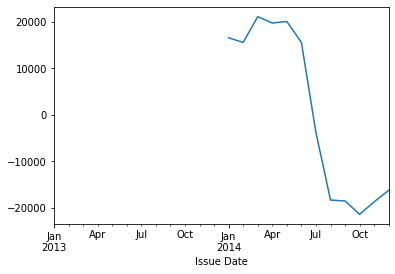

In [359]:
finecount_bydate_after2000['DODGE']['Seasonal First Difference'].plot()

###### Toyota

In [360]:
adfuller_test(finecount_bydate_after2000['TOYOT']['Fines'])

ADF Test Statistic : -1.8282968842937473
p-value : 0.36650630253396327
#Lags Used : 9
Number of Observations Used : 14
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [361]:
finecount_bydate_after2000['TOYOT']['Fines First Difference'] = finecount_bydate_after2000['TOYOT']['Fines'] - finecount_bydate_after2000['TOYOT']['Fines'].shift(1)
finecount_bydate_after2000['TOYOT'].head()

,Fines,Fines First Difference
Issue Date,,
2013-01-31,71,NaN
2013-02-28,19,-52.0
2013-03-31,23,4.0
2013-04-30,33,10.0
2013-05-31,11,-22.0


In [371]:
finecount_bydate_after2000['TOYOT']['Seasonal First Difference']=finecount_bydate_after2000['TOYOT']['Fines']-finecount_bydate_after2000['TOYOT']['Fines'].shift(12)
finecount_bydate_after2000['TOYOT'].head(20)

,Fines,Fines First Difference,Seasonal First Difference
Issue Date,,,
2013-01-31,71,NaN,NaN
2013-02-28,19,-52.0,NaN
2013-03-31,23,4.0,NaN
2013-04-30,33,10.0,NaN
2013-05-31,11,-22.0,NaN
2013-06-30,188,177.0,NaN
2013-07-31,11442,11254.0,NaN
2013-08-31,54748,43306.0,NaN
2013-09-30,52830,-1918.0,NaN


In [363]:
adfuller_test(finecount_bydate_after2000['TOYOT']['Seasonal First Difference'].dropna())

ADF Test Statistic : 0.08316228626064116
p-value : 0.9648925242036938
#Lags Used : 4
Number of Observations Used : 7
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<AxesSubplot:xlabel='Issue Date'>

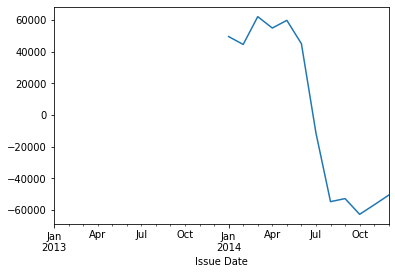

In [364]:
finecount_bydate_after2000['TOYOT']['Seasonal First Difference'].plot()

###### Hyundai

In [365]:
adfuller_test(finecount_bydate_after2000['HYUND']['Fines'])

ADF Test Statistic : -1.4248557874650958
p-value : 0.5703036518286068
#Lags Used : 9
Number of Observations Used : 13
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [366]:
finecount_bydate_after2000['HYUND']['Fines First Difference'] = finecount_bydate_after2000['HYUND']['Fines'] - finecount_bydate_after2000['HYUND']['Fines'].shift(1)
finecount_bydate_after2000['HYUND'].head()

,Fines,Fines First Difference
Issue Date,,
2013-01-31,22,NaN
2013-02-28,0,-22.0
2013-03-31,10,10.0
2013-04-30,16,6.0
2013-05-31,6,-10.0


In [367]:
finecount_bydate_after2000['HYUND']['Seasonal First Difference']=finecount_bydate_after2000['HYUND']['Fines']-finecount_bydate_after2000['HYUND']['Fines'].shift(12)
finecount_bydate_after2000['HYUND'].head(20)

,Fines,Fines First Difference,Seasonal First Difference
Issue Date,,,
2013-01-31,22,NaN,NaN
2013-02-28,0,-22.0,NaN
2013-03-31,10,10.0,NaN
2013-04-30,16,6.0,NaN
2013-05-31,6,-10.0,NaN
2013-06-30,35,29.0,NaN
2013-07-31,2903,2868.0,NaN
2013-08-31,13331,10428.0,NaN
2013-09-30,12944,-387.0,NaN


In [368]:
adfuller_test(finecount_bydate_after2000['HYUND']['Seasonal First Difference'].dropna())

ADF Test Statistic : -0.27034286953423037
p-value : 0.9296009086542498
#Lags Used : 0
Number of Observations Used : 10
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<AxesSubplot:xlabel='Issue Date'>

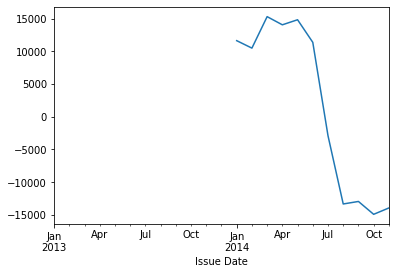

In [369]:
finecount_bydate_after2000['HYUND']['Seasonal First Difference'].plot()

Как видно выше, большинство машин получают примерно одинаковое количество штрафов, независимо от марки и года выпуска. При этом большая часть приведенных выше марок получали меньше штрафов в период с 2014-02 по 2014-07 (январь - июль) по сравнении за предыдущий год. В период с 2014-07 по 2014-09 количество штрафов было практически таким же как и год назад. В остально период, у таких марок как Dodge (До 2000 года) и Toyota (До 2000 года) количество штрафов увеличилось, но не сильно по сравнению с предыдущим годом, у Dodge(После 2000 года) и Hyundai (После 2000 года) количество штрафов увеличилось сильнее по сравнению с предыдущим годом, а у Toyota (После 2000 года) и штрафов прибавилось аж на 60000 по сравнении с предыдущем годом. У Hyundai (До 2000 года) количество штрафов уменьшалось на протяжении всего времени в соответствии с полученными данными.